In [1]:
import tensorflow as tf

tf.__version__

'2.7.0'

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16585900098895624549
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6267797504
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14808169716892447926
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070 Super with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
from music21 import *
import pandas as pd
import sys
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
from __future__ import print_function, division
from music21 import converter, instrument, note, chord, stream
from tensorflow.keras.layers import Input, Dense, Reshape, Dropout, Bidirectional
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from keras.layers import CuDNNLSTM

In [4]:
from music21 import converter, instrument, note, chord
import glob

notes = []
durations = []


for file in glob.glob('Moz/*.mid') :
    try :
        midi = converter.parse(file) 
        notes_to_parse = None
    except :
        print(file)
    try:      
        parts = instrument.partitionByInstrument(midi)
    except TypeError:
        print('## 1 {} 파일 읽기 에러.'.format(file))
    if parts: 
        print('## 2 {} 여러 악기 사용 파일'.format(file))
        notes_to_parse = parts.parts[0].recurse()
    else: 
        print('## 3 {} 단일 악기 사용 파일'.format(file))
        notes_to_parse = midi.flat.notes
        
    for element in notes_to_parse:

        if isinstance(element, chord.Chord):
            notes.append('.'.join(n.nameWithOctave for n in element.pitches))
            durations.append(element.duration.quarterLength)

        if isinstance(element, note.Note):
            if element.isRest:
                notes.append(str(element.name))
                durations.append(element.duration.quarterLength)
            else:
                notes.append(str(element.nameWithOctave))
                durations.append(element.duration.quarterLength)

## 3 Moz\Mozart_K331_1st-mov_p01.mid 단일 악기 사용 파일
## 3 Moz\Mozart_K331_1st-mov_p02.mid 단일 악기 사용 파일
## 3 Moz\Mozart_K331_1st-mov_p03.mid 단일 악기 사용 파일
## 3 Moz\Mozart_K331_1st-mov_p04.mid 단일 악기 사용 파일
## 3 Moz\Mozart_K331_1st-mov_p05.mid 단일 악기 사용 파일
## 3 Moz\Mozart_K331_1st-mov_p06.mid 단일 악기 사용 파일
## 3 Moz\Mozart_K331_1st-mov_p07.mid 단일 악기 사용 파일
## 3 Moz\Mozart_K331_1st-mov_p08.mid 단일 악기 사용 파일
## 3 Moz\Mozart_K331_1st-mov_p09.mid 단일 악기 사용 파일
## 3 Moz\Mozart_K331_1st-mov_p10.mid 단일 악기 사용 파일
## 3 Moz\Mozart_K331_1st-mov_p11.mid 단일 악기 사용 파일
## 3 Moz\Mozart_K331_1st-mov_p12.mid 단일 악기 사용 파일
## 3 Moz\Mozart_K331_1st-mov_p13.mid 단일 악기 사용 파일
## 3 Moz\Mozart_K331_1st-mov_p14.mid 단일 악기 사용 파일
## 3 Moz\Mozart_K331_1st-mov_p15.mid 단일 악기 사용 파일
## 3 Moz\Mozart_K331_1st-mov_p16.mid 단일 악기 사용 파일
## 3 Moz\Mozart_K331_1st-mov_p17.mid 단일 악기 사용 파일
## 3 Moz\Mozart_K331_1st-mov_p18.mid 단일 악기 사용 파일
## 3 Moz\Mozart_K331_1st-mov_p19.mid 단일 악기 사용 파일
## 3 Moz\Mozart_K331_1st-mov_p20.mid 단일 악기 사용 파일
## 3 Moz\Mozart_K331

In [5]:
print('\nduration', 'pitch')
for n,d in zip(notes,durations):
    print(d, '\t', n)


duration pitch
1.0 	 C#5.E4.A3
1/3 	 D5.B3
0.5 	 C#5.E4.A3
1.0 	 E5.E4.C#4
0.25 	 E5.C#4.E4
2/3 	 B4.E4.G#3
1/3 	 B4.E4.G#3
1/3 	 C#5.A3
0.5 	 B4.G#3.E4
1.0 	 D5.E4.B3
0.25 	 D5.B3.E4
1.0 	 A4.E4.F#3
0.5 	 A4.F#3
0.5 	 E4.F#3
1/3 	 B4.E4.G#3
2/3 	 B4.E4.G#3
0.5 	 B4.G#3
0.5 	 E4.G#3
0.5 	 C#5.A3.E4
2/3 	 E5
1.0 	 B4.D3
2/3 	 D5
2.0 	 C#5
0.25 	 E3
1.0 	 A4
2.0 	 E3
0.25 	 B4.G#4
1.0 	 C#5.E4.A3
1/3 	 B3.D5
0.5 	 C#5.A3.E4
2/3 	 E5.C#4.E4
1/12 	 E5.C#4.E4
0.25 	 E5.C#4.E4
1.25 	 B4.E4
0.75 	 G#3
0.5 	 A3.C#5
0.25 	 B4.G#3
0.5 	 E4
5/12 	 B4.G#3
0.75 	 D5.B3.E4
2/3 	 D5
1/3 	 B3.E4
1/3 	 A4
1/3 	 E4.F#3
17/12 	 A4
2/3 	 E4.F#3
0.75 	 B4
0.5 	 E4.G#3
2/3 	 C#5.A3
2/3 	 E4.A3
1.0 	 D5.D3
2/3 	 F#4.B4
1.0 	 C#5.E4.A4
4/3 	 E3
0.5 	 B4.E2.G#4
1/3 	 D4
1.0 	 A4.A2.E4.C#4
1/3 	 C#5.A3.E4
11/12 	 C#5.A3.E4
1/3 	 B3.D5
0.5 	 C#5.A3.E4
0.75 	 E5.C#4.E4
0.25 	 E5.C#4.E4
1.0 	 B4.G#3.E4
0.25 	 C#5.A3
0.5 	 B4.G#3.E4
0.25 	 D5.E4.B3
0.5 	 D5.E4.B3
0.25 	 D5.E4.B3
0.75 	 A4.E4.F#3
0.5 	 A4.E4.F#3
0.

0.75 	 A3
1/3 	 D5.B3
1.0 	 C#5.A3
0.5 	 E4
1.0 	 E5.E4.C#4
1.5 	 E5
0.5 	 E4
1.0 	 C#4
0.75 	 B4.E4.G#3
1/3 	 C#5.A3
1.0 	 B4.G#3
0.5 	 E4
0.25 	 D5.E4.B3
0.5 	 D5.E4.B3
1.0 	 D5.B3
0.5 	 E4
5/3 	 A4
1.0 	 E4.F#3
1.0 	 B4
0.75 	 E4.G#3
1/12 	 A4
2/3 	 C#5.E4.A3
2/3 	 D5.F#4
1.0 	 B4.D3
1/3 	 C#5.A4.E4
0.25 	 E3
5/12 	 C#5.A4.E4
1.75 	 E3
1.25 	 B4.G#4.E2
1/3 	 D4
1.25 	 A4.E4.C#4
1.0 	 A2.C#4
0.25 	 A2.C#4
1.25 	 E5
0.75 	 A3
2/3 	 C#4
0.5 	 F#5
1/3 	 E5.E4
1/3 	 E5.E4
0.75 	 F#5.A3
0.75 	 D4
0.25 	 F#5
1.0 	 F#4
0.25 	 F#5.G#5
1.0 	 A5.A3
1/3 	 D4
0.5 	 G#5
5/12 	 D4
0.5 	 F#5
1.0 	 F#4
1.0 	 F#5
1.5 	 A3
0.25 	 E5
0.75 	 C#4
0.25 	 E5.E4
2/3 	 E5.C#4.A3
1/12 	 E5.C#4.A3
0.25 	 C#5
0.25 	 A4
2/3 	 E5.D4.G#3
0.25 	 D5
0.25 	 B4
0.75 	 E5.C#4.A3
0.25 	 C#5
1/3 	 A4.E-4.F#3
1.25 	 C#5.A4
1.25 	 E4.E3
0.75 	 C#5.A4
13/12 	 E4.E3
0.5 	 B4.G#4
1.25 	 C#5.E4
1.25 	 A3.E4
0.5 	 D5.B3
0.25 	 C#5.A3
0.25 	 E4
0.75 	 C#5.A3
0.25 	 E4
0.75 	 E5.E4.C#4
1.5 	 E5
1.0 	 C#4
2/3 	 E4
2/3 	 B4.E4
0.5 

1.5 	 A4
0.5 	 E3
1.0 	 C#4
0.5 	 C#5.G#4
1.25 	 E3.D4
0.75 	 B4
0.75 	 A4.C#4.A3
4/3 	 E5
5/3 	 A3
4/3 	 C#4
2/3 	 F#5
2/3 	 E5.E4
2/3 	 F#5
4/3 	 A3
1/12 	 E5.E4
1/6 	 C#4
5/3 	 D4
0.25 	 F#5
1.25 	 F#4
5/3 	 A3
1/3 	 F#5.G#5
1.25 	 A5
0.5 	 D4
1/3 	 G#5
0.5 	 F#4
0.25 	 F#5
5/6 	 D4
1/6 	 G#5
0.75 	 F#5
4/3 	 A3
0.25 	 E5
0.75 	 C#4
0.25 	 E5
0.75 	 E4
0.75 	 E5.C#4.A3
0.25 	 C#5
0.25 	 A4
0.75 	 D4.E5.G#3
0.25 	 D5
0.25 	 B4
0.5 	 E5.C#4.A3
0.25 	 C#5
0.25 	 E-4.A4.F#3
1.0 	 C#5
2.0 	 A4
7/3 	 E4
0.25 	 E3
7/3 	 E3
1/3 	 B4.G#4
1/6 	 E3
1.0 	 C#5.A3
1.5 	 E4
0.25 	 D5.B3
1.0 	 C#5.A3
1/3 	 E4
0.5 	 E5.E4.C#4
0.25 	 E5.E4.C#4
1.0 	 B4.E4.G#3
1/3 	 C#5.A3
1.0 	 G#3.B4
1/3 	 E4
0.25 	 D5.E4.B3
5/12 	 D5.E4.B3
0.25 	 E4.B3
1.0 	 D5
0.75 	 B3
0.75 	 E4
1.5 	 A4.F#3
0.5 	 B4.G#3
1/3 	 E4
0.5 	 B4.G#3
2/3 	 E4
1.0 	 C#5
1.75 	 A3
1.25 	 D5.D3
0.5 	 B4.F#4
0.75 	 E3
0.5 	 C#5.A4.E4
0.25 	 E4
1.0 	 E3
0.5 	 B4.G#4.E4
1.0 	 E2
4/3 	 B4
2.25 	 A2.E4
2/3 	 G#4
0.25 	 C#5.A4.A4
1.5 	 C#5.A2
0.7

0.5 	 C#5.E4.A4.A3
1/3 	 A2
0.5 	 C#5.E4.A4.A3
2/3 	 A2
0.5 	 D5.G#4.E4.B2.B3
1.0 	 E5.A4.C#3.C#4.E4
4/3 	 F#5.D4.D3
1/3 	 G#5
0.75 	 A5
0.5 	 E3
0.5 	 A4
0.5 	 C#4
3.5 	 E3
2.25 	 A4
7/6 	 C#4
1.25 	 C#5.G#4
1.75 	 D4
1.0 	 B4
1.25 	 D4
0.75 	 B4
1.25 	 A4.C#4.A3
4/3 	 C#5.A3.E4
0.25 	 B3.D5
0.75 	 C#5.A3
0.5 	 E4
0.25 	 C#5.A3
0.75 	 E5.E4.C#4
0.25 	 E5.E4.C#4
1.0 	 B4.G#3.E4
0.5 	 B4.G#3.E4
1/3 	 C#5.A3
1.0 	 B4.G#3
0.5 	 E4
0.75 	 D5.E4.B3
0.25 	 D5.B3.E4
1/12 	 D5.B3.E4
1.0 	 E4.A4.F#3
0.5 	 A4.E4.F#3
0.5 	 B4.E4.G#3
0.25 	 B4.E4.G#3
1/3 	 B4.E4.G#3
0.75 	 E4
1.75 	 C#5.A3
0.25 	 E5
0.25 	 B4.D3
0.25 	 E5
0.75 	 B4.D3
0.5 	 D5
2.0 	 C#5.A4
7/3 	 E3
1/3 	 B4.G#4
4/3 	 C#5.E4.A3
0.25 	 B3.D5
1.0 	 C#5.A3
0.5 	 E4
1.0 	 E5.E4.C#4
1/3 	 E5.E4.C#4
1.5 	 B4.E4.G#3
0.25 	 C#5.A3
0.5 	 B4.G#3
0.5 	 E4
0.5 	 B4.G#3
1/6 	 E4
1.0 	 E4.D5.B3
0.25 	 D5.E4.B3
2/3 	 A4.F#3
2/3 	 E4
4/3 	 A4.F#3
7/12 	 E4
1.0 	 B4.G#3
2/3 	 E4
0.75 	 E4.C#5
1.75 	 A3
0.5 	 D5
1.25 	 F#4.B4.D3
0.25 	 A3
0.75 	 C#5

0.75 	 D5.E4.B3
1/3 	 D5.E4.B3
0.5 	 A4.E4.F#3
0.75 	 A4.E4.F#3
2/3 	 F#3.E4
1.25 	 A4
1.0 	 B4.G#3.E4
0.5 	 E4.G#3
0.5 	 B4
0.25 	 E4.G#3
0.75 	 B4
2/3 	 E4.A3
2.0 	 C#5
2/3 	 E5.B4
1.25 	 D3
1/3 	 D5
2/3 	 E3.C#5
2/3 	 A4
4/3 	 E3.C#5
7/12 	 A4
0.5 	 B4.G#4
1.25 	 C#5.E4.A3
0.25 	 D5.B3
0.25 	 D5.B3
0.5 	 C#5.E4
0.75 	 A3
1.0 	 E5.E4.C#4
0.25 	 E5.E4.C#4
1/3 	 B4.E4.G#3
2/3 	 B4.E4.G#3
0.5 	 A3.C#5
1.0 	 G#3
0.5 	 B4.E4
0.75 	 E4.D5.B3
0.25 	 D5.E4.B3
1/12 	 D5.E4.B3
1.0 	 E4
1.75 	 A4.F#3
0.5 	 E4.G#3
1.0 	 B4
0.5 	 C#5.A3
0.5 	 E4.A3
0.5 	 D5.F#4
1/3 	 B4
1.0 	 D3
1.25 	 C#5.E4.E3
0.75 	 A4
1/3 	 D4.G#4.B4
4/3 	 E2
2.0 	 E4.A4.C#4
5/3 	 A2
5/3 	 E5
2.0 	 A3
1.0 	 C#4
1/3 	 F#5
0.75 	 E4
0.5 	 E5
1.75 	 A3
1.25 	 F#5
1.0 	 D4
0.5 	 F#5.F#4
1/3 	 F#5
1/3 	 G#5
1.5 	 A3
1.0 	 A5
0.75 	 D4
0.25 	 A5
1/3 	 G#5
1/3 	 F#4.F#5
1/6 	 A3
0.25 	 D4
1/6 	 G#5
2.0 	 A3
2/3 	 F#5
0.25 	 E5
1.25 	 C#4
0.25 	 E4.E5
0.5 	 E5.A3.C#4
0.75 	 E5.A3.C#4
0.25 	 C#5
0.25 	 A4
0.75 	 E5.D4.G#3
0.25 	 D5
0.

0.75 	 E5.E4.C#4
0.25 	 E5.E4.C#4
1.0 	 B4.E4.G#3
1/3 	 C#5.A3
0.5 	 B4.G#3.E4
0.75 	 D5.E4.B3
1.25 	 D5
0.25 	 E4.B3
1.5 	 A4
1.0 	 F#3.E4
0.5 	 B4.E4.G#3
0.5 	 A4
0.5 	 C#5.E4.A3
1.25 	 D5
0.5 	 B4.F#4
0.75 	 D3
0.25 	 C#5.E4.A4
2.0 	 E3
0.5 	 C#5.E4.A4
0.5 	 B4.G#4.E2.D4
1.0 	 A4.A2.E4
1.0 	 C#4
0.25 	 A4.A2.E4
1.25 	 C#5.E4.A3
0.25 	 B3.D5
2/3 	 A3.C#5
1.0 	 E5.E4.C#4
0.25 	 E5.E4.C#4
1.25 	 B4.E4
0.75 	 G#3
0.25 	 C#5.A3
0.5 	 B4.E4.G#3
0.75 	 D5.E4.B3
1.5 	 D5
0.25 	 E4.B3
1.25 	 A4.E4.F#3
1/3 	 A4.F#3.E4
1.0 	 B4.E4.G#3
0.25 	 B4
1/3 	 G#3.E4
1/3 	 C#5
1/3 	 A3.E4
1.0 	 C#5
5/12 	 A3.E4
0.5 	 E5.B4.D3
0.75 	 D5
1.25 	 C#5
1.25 	 E3
1.0 	 A4
0.25 	 C#5
1.25 	 E3
0.5 	 B4.G#4
1.25 	 C#5.E4.A3
0.25 	 D5.B3
1/3 	 E4
2/3 	 C#5
1.0 	 A3
2/3 	 E5.E4.C#4
0.25 	 E5.C#4.E4
1.0 	 B4.G#3
1.25 	 E4
1/3 	 C#5.A3
0.75 	 B4.G#3
0.5 	 E4
2/3 	 D5
0.75 	 E4.B3
4/3 	 D5
0.25 	 E4.B3
1.75 	 A4
1.0 	 F#3.E4
0.75 	 B4.E4.G#3
0.5 	 C#5.E4.A3
1.25 	 D5
0.5 	 B4.F#4
0.75 	 D3
1.0 	 C#5.A4.E4
1.0 	 E3
1.

In [7]:
len(notes)

6851

In [6]:
from keras.utils import np_utils

n_vocab = len(set(notes))
n_dur = len(set(durations))

sequence_length = 100
# 모든 계이름의 이름을 pitchnames 변수에 저장.
# set 으로 중복을 피하고, sorted 함수로 정렬함.
pitchnames = sorted(set(item for item in notes))
durnames = sorted(set(d for d in durations))

# 각 계이름을 숫자로 바꾸는 dictionary(사전)을 만든다.
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
duration_to_int = dict((d, number) for number, d in enumerate(durnames))

notes_network_input = []
notes_network_output = []

durations_network_input = [] #duration 관련 input
durations_network_output = []



# 입력 시퀀스를 만든다.
for i in range(0, len(notes) - sequence_length, 1):
    notes_sequence_in = notes[i:i + sequence_length]
    notes_sequence_out = notes[i + sequence_length]
    notes_network_input.append([note_to_int[char] for char in notes_sequence_in])
    notes_network_output.append(note_to_int[notes_sequence_out])
    
    durations_sequence_in = durations[i:i + sequence_length]
    durations_sequence_out = durations[i + sequence_length]
    durations_network_input.append([duration_to_int[dur] for dur in durations_sequence_in])
    durations_network_output.append(duration_to_int[durations_sequence_out])

n_patterns = len(notes_network_input)

# 데이터 입력 형태를 LSTM 레이어에 알맞게 변경함.
notes_network_input = np.reshape(notes_network_input, (n_patterns, sequence_length))  ###
notes_network_input = notes_network_input / float(n_vocab)
durations_network_input = np.reshape(durations_network_input, (n_patterns, sequence_length))####

network_input = [notes_network_input, durations_network_input]


notes_network_output = np_utils.to_categorical(notes_network_output, num_classes=n_vocab)
durations_network_output = np_utils.to_categorical(durations_network_output, num_classes=n_dur)

network_output = [notes_network_output, durations_network_output]




In [10]:
notes_network_input.shape

(6751, 100)

In [11]:
n_dur

41

In [12]:
n_vocab

350

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation, Embedding,Concatenate
from keras.layers import CuDNNLSTM
from tensorflow.keras.optimizers import RMSprop

In [14]:
embed_size = 100

notes_in = Input(shape = (None,))
durations_in = Input(shape = (None,))

x1 = Embedding(n_vocab, embed_size)(notes_in)
x2 = Embedding(n_dur, embed_size)(durations_in) 

x = Concatenate()([x1,x2])

x = CuDNNLSTM(256, return_sequences=True)(x)
x = Dropout(0.3)(x)

x = CuDNNLSTM(512, return_sequences=True)(x)
x = Dropout(0.3)(x)

y = CuDNNLSTM(256)(x)
y = Dropout(0.3)(y)

notes_out = Dense(n_vocab, activation = 'softmax', name = 'pitch')(y)
durations_out = Dense(n_dur, activation = 'softmax', name = 'duration')(y)

model = Model([notes_in, durations_in], [notes_out, durations_out])

opti = RMSprop(learning_rate = 0.001)
model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer=opti)


In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 100)    35000       ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 100)    4100        ['input_2[0][0]']                
                                                                                              

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

filepath = "./Moz/weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"    
checkpoint = ModelCheckpoint(
    filepath, monitor='loss',
    verbose=1,        
    save_best_only=True,        
    mode='min'
)
earlystopping = EarlyStopping(monitor='loss', patience =10)

callbacks_list = [checkpoint,earlystopping ]     

history = model.fit(network_input, network_output, epochs=300, batch_size=64, callbacks=callbacks_list,
                   validation_split = 0.2)
#weights-improvement-178-0.0929-bigger.hdf5

Epoch 1/300
85/85 [==============================] - ETA: 0s - loss: 6.9853 - pitch_loss: 4.4598 - duration_loss: 2.5255
Epoch 00001: loss improved from inf to 6.98529, saving model to ./Moz\weights-improvement-01-6.9853-bigger.hdf5
85/85 [==============================] - 5s 54ms/step - loss: 6.9853 - pitch_loss: 4.4598 - duration_loss: 2.5255 - val_loss: 7.1027 - val_pitch_loss: 4.6639 - val_duration_loss: 2.4388
Epoch 2/300
85/85 [==============================] - ETA: 0s - loss: 6.9625 - pitch_loss: 4.4398 - duration_loss: 2.5226
Epoch 00002: loss improved from 6.98529 to 6.96248, saving model to ./Moz\weights-improvement-02-6.9625-bigger.hdf5
85/85 [==============================] - 5s 54ms/step - loss: 6.9625 - pitch_loss: 4.4398 - duration_loss: 2.5226 - val_loss: 7.1081 - val_pitch_loss: 4.6545 - val_duration_loss: 2.4536
Epoch 3/300
84/85 [============================>.] - ETA: 0s - loss: 6.9201 - pitch_loss: 4.4040 - duration_loss: 2.5161 ETA: 2s - loss:
Epoch 00003: loss imp

84/85 [============================>.] - ETA: 0s - loss: 4.8567 - pitch_loss: 2.5800 - duration_loss: 2.2766
Epoch 00020: loss improved from 4.98582 to 4.85790, saving model to ./Moz\weights-improvement-20-4.8579-bigger.hdf5
85/85 [==============================] - 5s 56ms/step - loss: 4.8579 - pitch_loss: 2.5801 - duration_loss: 2.2778 - val_loss: 7.9162 - val_pitch_loss: 5.3283 - val_duration_loss: 2.5878
Epoch 21/300
84/85 [============================>.] - ETA: 0s - loss: 4.7529 - pitch_loss: 2.5069 - duration_loss: 2.2460
Epoch 00021: loss improved from 4.85790 to 4.75204, saving model to ./Moz\weights-improvement-21-4.7520-bigger.hdf5
85/85 [==============================] - 5s 56ms/step - loss: 4.7520 - pitch_loss: 2.5055 - duration_loss: 2.2465 - val_loss: 7.6280 - val_pitch_loss: 5.0783 - val_duration_loss: 2.5497
Epoch 22/300
84/85 [============================>.] - ETA: 0s - loss: 4.6019 - pitch_loss: 2.3842 - duration_loss: 2.2178
Epoch 00022: loss improved from 4.75204 to 

Epoch 40/300
84/85 [============================>.] - ETA: 0s - loss: 2.4790 - pitch_loss: 1.0790 - duration_loss: 1.4000
Epoch 00040: loss improved from 2.59761 to 2.47825, saving model to ./Moz\weights-improvement-40-2.4783-bigger.hdf5
85/85 [==============================] - 5s 57ms/step - loss: 2.4783 - pitch_loss: 1.0787 - duration_loss: 1.3996 - val_loss: 9.8785 - val_pitch_loss: 6.6068 - val_duration_loss: 3.2716
Epoch 41/300
85/85 [==============================] - ETA: 0s - loss: 2.3659 - pitch_loss: 1.0501 - duration_loss: 1.3158
Epoch 00041: loss improved from 2.47825 to 2.36588, saving model to ./Moz\weights-improvement-41-2.3659-bigger.hdf5
85/85 [==============================] - 5s 57ms/step - loss: 2.3659 - pitch_loss: 1.0501 - duration_loss: 1.3158 - val_loss: 10.0075 - val_pitch_loss: 6.6590 - val_duration_loss: 3.3485
Epoch 42/300
84/85 [============================>.] - ETA: 0s - loss: 2.2968 - pitch_loss: 1.0115 - duration_loss: 1.2853
Epoch 00042: loss improved fr

84/85 [============================>.] - ETA: 0s - loss: 1.1405 - pitch_loss: 0.5266 - duration_loss: 0.6139
Epoch 00059: loss improved from 1.16186 to 1.13877, saving model to ./Moz\weights-improvement-59-1.1388-bigger.hdf5
85/85 [==============================] - 5s 57ms/step - loss: 1.1388 - pitch_loss: 0.5256 - duration_loss: 0.6131 - val_loss: 11.8223 - val_pitch_loss: 7.3562 - val_duration_loss: 4.4661
Epoch 60/300
84/85 [============================>.] - ETA: 0s - loss: 1.0748 - pitch_loss: 0.5042 - duration_loss: 0.5706
Epoch 00060: loss improved from 1.13877 to 1.07313, saving model to ./Moz\weights-improvement-60-1.0731-bigger.hdf5
85/85 [==============================] - 5s 57ms/step - loss: 1.0731 - pitch_loss: 0.5031 - duration_loss: 0.5700 - val_loss: 11.7258 - val_pitch_loss: 7.3022 - val_duration_loss: 4.4236
Epoch 61/300
85/85 [==============================] - ETA: 0s - loss: 1.0422 - pitch_loss: 0.4867 - duration_loss: 0.5555
Epoch 00061: loss improved from 1.07313 t

Epoch 97/300
84/85 [============================>.] - ETA: 0s - loss: 0.3384 - pitch_loss: 0.1703 - duration_loss: 0.1681
Epoch 00097: loss improved from 0.35100 to 0.33881, saving model to ./Moz\weights-improvement-97-0.3388-bigger.hdf5
85/85 [==============================] - 5s 56ms/step - loss: 0.3388 - pitch_loss: 0.1706 - duration_loss: 0.1682 - val_loss: 14.4334 - val_pitch_loss: 8.3671 - val_duration_loss: 6.0663
Epoch 98/300
84/85 [============================>.] - ETA: 0s - loss: 0.3230 - pitch_loss: 0.1656 - duration_loss: 0.1574
Epoch 00098: loss improved from 0.33881 to 0.32307, saving model to ./Moz\weights-improvement-98-0.3231-bigger.hdf5
85/85 [==============================] - 5s 57ms/step - loss: 0.3231 - pitch_loss: 0.1653 - duration_loss: 0.1578 - val_loss: 14.3812 - val_pitch_loss: 8.3238 - val_duration_loss: 6.0574
Epoch 99/300
85/85 [==============================] - ETA: 0s - loss: 0.3182 - pitch_loss: 0.1573 - duration_loss: 0.1610
Epoch 00099: loss improved f

Epoch 117/300
84/85 [============================>.] - ETA: 0s - loss: 0.2285 - pitch_loss: 0.1175 - duration_loss: 0.1110 ETA: 3s - loss: 0.1961 - pitch_loss: 0.1088 - duration_loss: 0.08 - - ETA: 1s - loss: 0.224
Epoch 00117: loss did not improve from 0.21875
85/85 [==============================] - 5s 56ms/step - loss: 0.2279 - pitch_loss: 0.1172 - duration_loss: 0.1107 - val_loss: 15.3350 - val_pitch_loss: 8.7092 - val_duration_loss: 6.6258
Epoch 118/300
84/85 [============================>.] - ETA: 0s - loss: 0.2109 - pitch_loss: 0.1034 - duration_loss: 0.1076 ETA: 0s - loss: 0.2064 - pitch_loss: 0.1004 - duration_lo - ETA: 0s - loss: 0.2092 - pitch_loss: 0.1020 - duration_loss:  - ETA: 0s - loss: 0.2121 - pitch_loss: 0.1041 - duration_loss: 0.
Epoch 00118: loss improved from 0.21875 to 0.21056, saving model to ./Moz\weights-improvement-118-0.2106-bigger.hdf5
85/85 [==============================] - 5s 57ms/step - loss: 0.2106 - pitch_loss: 0.1032 - duration_loss: 0.1074 - val_los

Epoch 137/300
84/85 [============================>.] - ETA: 0s - loss: 0.1493 - pitch_loss: 0.0763 - duration_loss: 0.0730
Epoch 00137: loss improved from 0.15163 to 0.14987, saving model to ./Moz\weights-improvement-137-0.1499-bigger.hdf5
85/85 [==============================] - 5s 56ms/step - loss: 0.1499 - pitch_loss: 0.0771 - duration_loss: 0.0727 - val_loss: 15.8180 - val_pitch_loss: 8.7622 - val_duration_loss: 7.0558
Epoch 138/300
85/85 [==============================] - ETA: 0s - loss: 0.1550 - pitch_loss: 0.0778 - duration_loss: 0.0772 ETA: 1s - loss: 0.1536 - pitch_loss: 0.0751 - duration_lo - ETA: 1s - loss: 0.1551 - pi
Epoch 00138: loss did not improve from 0.14987
85/85 [==============================] - 5s 56ms/step - loss: 0.1550 - pitch_loss: 0.0778 - duration_loss: 0.0772 - val_loss: 15.8851 - val_pitch_loss: 8.8503 - val_duration_loss: 7.0348
Epoch 139/300
84/85 [============================>.] - ETA: 0s - loss: 0.1489 - pitch_loss: 0.0768 - duration_loss: 0.0721 ETA: 

Epoch 158/300
85/85 [==============================] - ETA: 0s - loss: 0.1263 - pitch_loss: 0.0602 - duration_loss: 0.0661
Epoch 00158: loss did not improve from 0.11792
85/85 [==============================] - 5s 58ms/step - loss: 0.1263 - pitch_loss: 0.0602 - duration_loss: 0.0661 - val_loss: 16.4046 - val_pitch_loss: 9.2254 - val_duration_loss: 7.1793
Epoch 159/300
84/85 [============================>.] - ETA: 0s - loss: 0.1295 - pitch_loss: 0.0641 - duration_loss: 0.0654
Epoch 00159: loss did not improve from 0.11792
85/85 [==============================] - 5s 56ms/step - loss: 0.1292 - pitch_loss: 0.0639 - duration_loss: 0.0653 - val_loss: 16.1842 - val_pitch_loss: 8.9950 - val_duration_loss: 7.1892
Epoch 160/300
84/85 [============================>.] - ETA: 0s - loss: 0.1215 - pitch_loss: 0.0609 - duration_loss: 0.0606
Epoch 00160: loss did not improve from 0.11792
85/85 [==============================] - 5s 56ms/step - loss: 0.1221 - pitch_loss: 0.0611 - duration_loss: 0.0610 - 

Epoch 180/300
84/85 [============================>.] - ETA: 0s - loss: 0.1002 - pitch_loss: 0.0470 - duration_loss: 0.0532
Epoch 00180: loss did not improve from 0.09288
85/85 [==============================] - 5s 56ms/step - loss: 0.1000 - pitch_loss: 0.0470 - duration_loss: 0.0531 - val_loss: 17.3432 - val_pitch_loss: 9.4840 - val_duration_loss: 7.8593
Epoch 181/300
84/85 [============================>.] - ETA: 0s - loss: 0.0930 - pitch_loss: 0.0458 - duration_loss: 0.0472
Epoch 00181: loss did not improve from 0.09288
85/85 [==============================] - 5s 56ms/step - loss: 0.0929 - pitch_loss: 0.0460 - duration_loss: 0.0470 - val_loss: 16.6791 - val_pitch_loss: 8.9483 - val_duration_loss: 7.7308
Epoch 182/300
84/85 [============================>.] - ETA: 0s - loss: 0.0976 - pitch_loss: 0.0459 - duration_loss: 0.0517 ETA: 
Epoch 00182: loss did not improve from 0.09288
85/85 [==============================] - 5s 56ms/step - loss: 0.0974 - pitch_loss: 0.0457 - duration_loss: 0.0

In [1]:
from tensorflow.keras.models import load_model
model = load_model('./Moz/weights-improvement-178-0.0929-bigger.hdf5')

In [7]:
import numpy as np 
# 입력 시퀀스를 랜덤하게 주는 부분.
start = np.random.randint(0, len(notes_network_input)-1)

# 숫자를 노트로 매핑하는 Dictionary 생성
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
int_to_duration = dict((number,d) for number, d in enumerate(durnames))

notes_pattern = notes_network_input[start]###
durations_pattern = durations_network_input[start]


prediction_output = []

for note_index in range(500):
    
    prediction_input = [np.array([notes_pattern]),
                       np.array([durations_pattern])]
        
    notes_prediction, duration_prediction = model.predict(prediction_input, verbose=0)
    
    n_index = np.argmax(notes_prediction)
    d_index = np.argmax(duration_prediction)
    
    note_result = int_to_note[n_index]
    duration_result = int_to_duration[d_index]
    prediction_output.append([note_result, duration_result])
    
    
    notes_pattern = np.append(notes_pattern, n_index)
    notes_pattern = notes_pattern[1:len(notes_pattern)]
    
    durations_pattern = np.append(durations_pattern, d_index)
    durations_pattern = durations_pattern[1:len(durations_pattern)]

In [9]:
notes_pattern

array([146.,  21.,  10., 173.,  60., 343., 275., 104., 238., 319., 162.,
       157., 346.,  55.,  30., 225., 225.,  30., 225., 116., 342., 162.,
        67., 162.,  25., 107.,  25., 107., 121., 238., 179., 116., 243.,
         9., 308.,   9., 300.,  67., 238., 330., 121.,  67., 330., 238.,
       199., 196.,  62.,  51.,  43., 311.,  84.,  82., 330., 116., 243.,
       157., 286., 173., 116., 225.,  21., 225., 225., 116.,  94., 116.,
       238.,   9., 179., 122., 272., 259., 308.,  84., 147.,  82., 330.,
       199., 196.,  62.,  52., 238.,  52.,  82., 330., 147., 190., 157.,
       157., 130., 225.,  73., 220.,  49.,   0.,  49.,   0., 116., 238.,
         9.])

In [13]:
prediction_output

[['E5.E4', Fraction(5, 3)],
 ['C#4', 1.75],
 ['E5.C#4', 0.5],
 ['E4', 0.75],
 ['B4.E4', 1.5],
 ['G#3', 1.5],
 ['B4.E4', 0.75],
 ['C#5', 0.75],
 ['A3', 0.25],
 ['B4.E4.G#3', 1.0],
 ['D5.E4.B3', 1.25],
 ['D5.E4.B3', 0.5],
 ['D5.E4', Fraction(2, 3)],
 ['B3', Fraction(5, 3)],
 ['A4.E4.F#3', 1.0],
 ['A4.E4.F#3', Fraction(2, 3)],
 ['A4.E4', Fraction(2, 3)],
 ['F#3', Fraction(5, 3)],
 ['B4.E4.G#3', 1.0],
 ['B4.E4.G#3', Fraction(2, 3)],
 ['B4', 1.5],
 ['E4.G#3', 0.75],
 ['C#5.A3', 1.0],
 ['E4', 1.0],
 ['E4', 1.75],
 ['E5', 0.75],
 ['B4', 1.25],
 ['D3', 2.0],
 ['D5', 1.0],
 ['C#5', 0.5],
 ['E3', 0.25],
 ['A4', 0.5],
 ['E3', 0.25],
 ['C#5', 1.0],
 ['E3', 3.0],
 ['A4', 1.25],
 ['B4.G#4', Fraction(2, 3)],
 ['C#5.E4.A3', 2.0],
 ['D5.B3', 0.5],
 ['C#5.A3.E4', 0.75],
 ['E5.E4.C#4', 1.5],
 ['E5.C#4', 0.5],
 ['E4', 0.5],
 ['B4.E4', 2.0],
 ['G#3', 1.25],
 ['C#5', Fraction(2, 3)],
 ['A3', 0.25],
 ['B4.G#3', 0.5],
 ['E4', 0.5],
 ['B4.G#3', 0.75],
 ['E4', 0.25],
 ['D5.E4.B3', 1.5],
 ['D5.E4', Fraction(1, 3

In [15]:
import time
midi_stream = stream.Stream()

# 모델이 생성한 값을 기반으로 악보와 화음 객체 만들기
for pattern in prediction_output:
    note_pattern, duration_pattern = pattern
    # 패턴이 화음일 경우
    if ('.' in note_pattern):
        notes_in_chord = note_pattern.split('.')
        chord_notes = []
        for current_note in notes_in_chord:
            new_note = note.Note((current_note))
            new_note.duration = duration.Duration(duration_pattern)
            new_note.storedInstrument = instrument.Piano()
            chord_notes.append(new_note)
        new_chord = chord.Chord(chord_notes)
        midi_stream.append(new_chord)
        
#     elif note_pattern == 'rest':
#     # 패턴이 쉼표일 경우
#         new_note = note.Rest()
#         new_note.duration = duration.Duration(duration_pattern)
#         new_note.storedInstrument = instrument.Violoncello()
#         midi_stream.append(new_note)
    else:
    # 패턴이 하나의 음표일 경우
        new_note = note.Note(note_pattern)
        new_note.duration = duration.Duration(duration_pattern)
        new_note.storedInstrument = instrument.Piano()
        midi_stream.append(new_note)



midi_stream = midi_stream
midi_stream.write('midi', fp='Moz_output2.mid')

'Moz_output2.mid'

In [17]:

## Setting up MuseScore.exe within Music21 environment
from music21 import environment

us = environment.Environment()    
us['musescoreDirectPNGPath'] = 'C:/Program Files/MuseScore 3/bin/MuseScore3.exe'


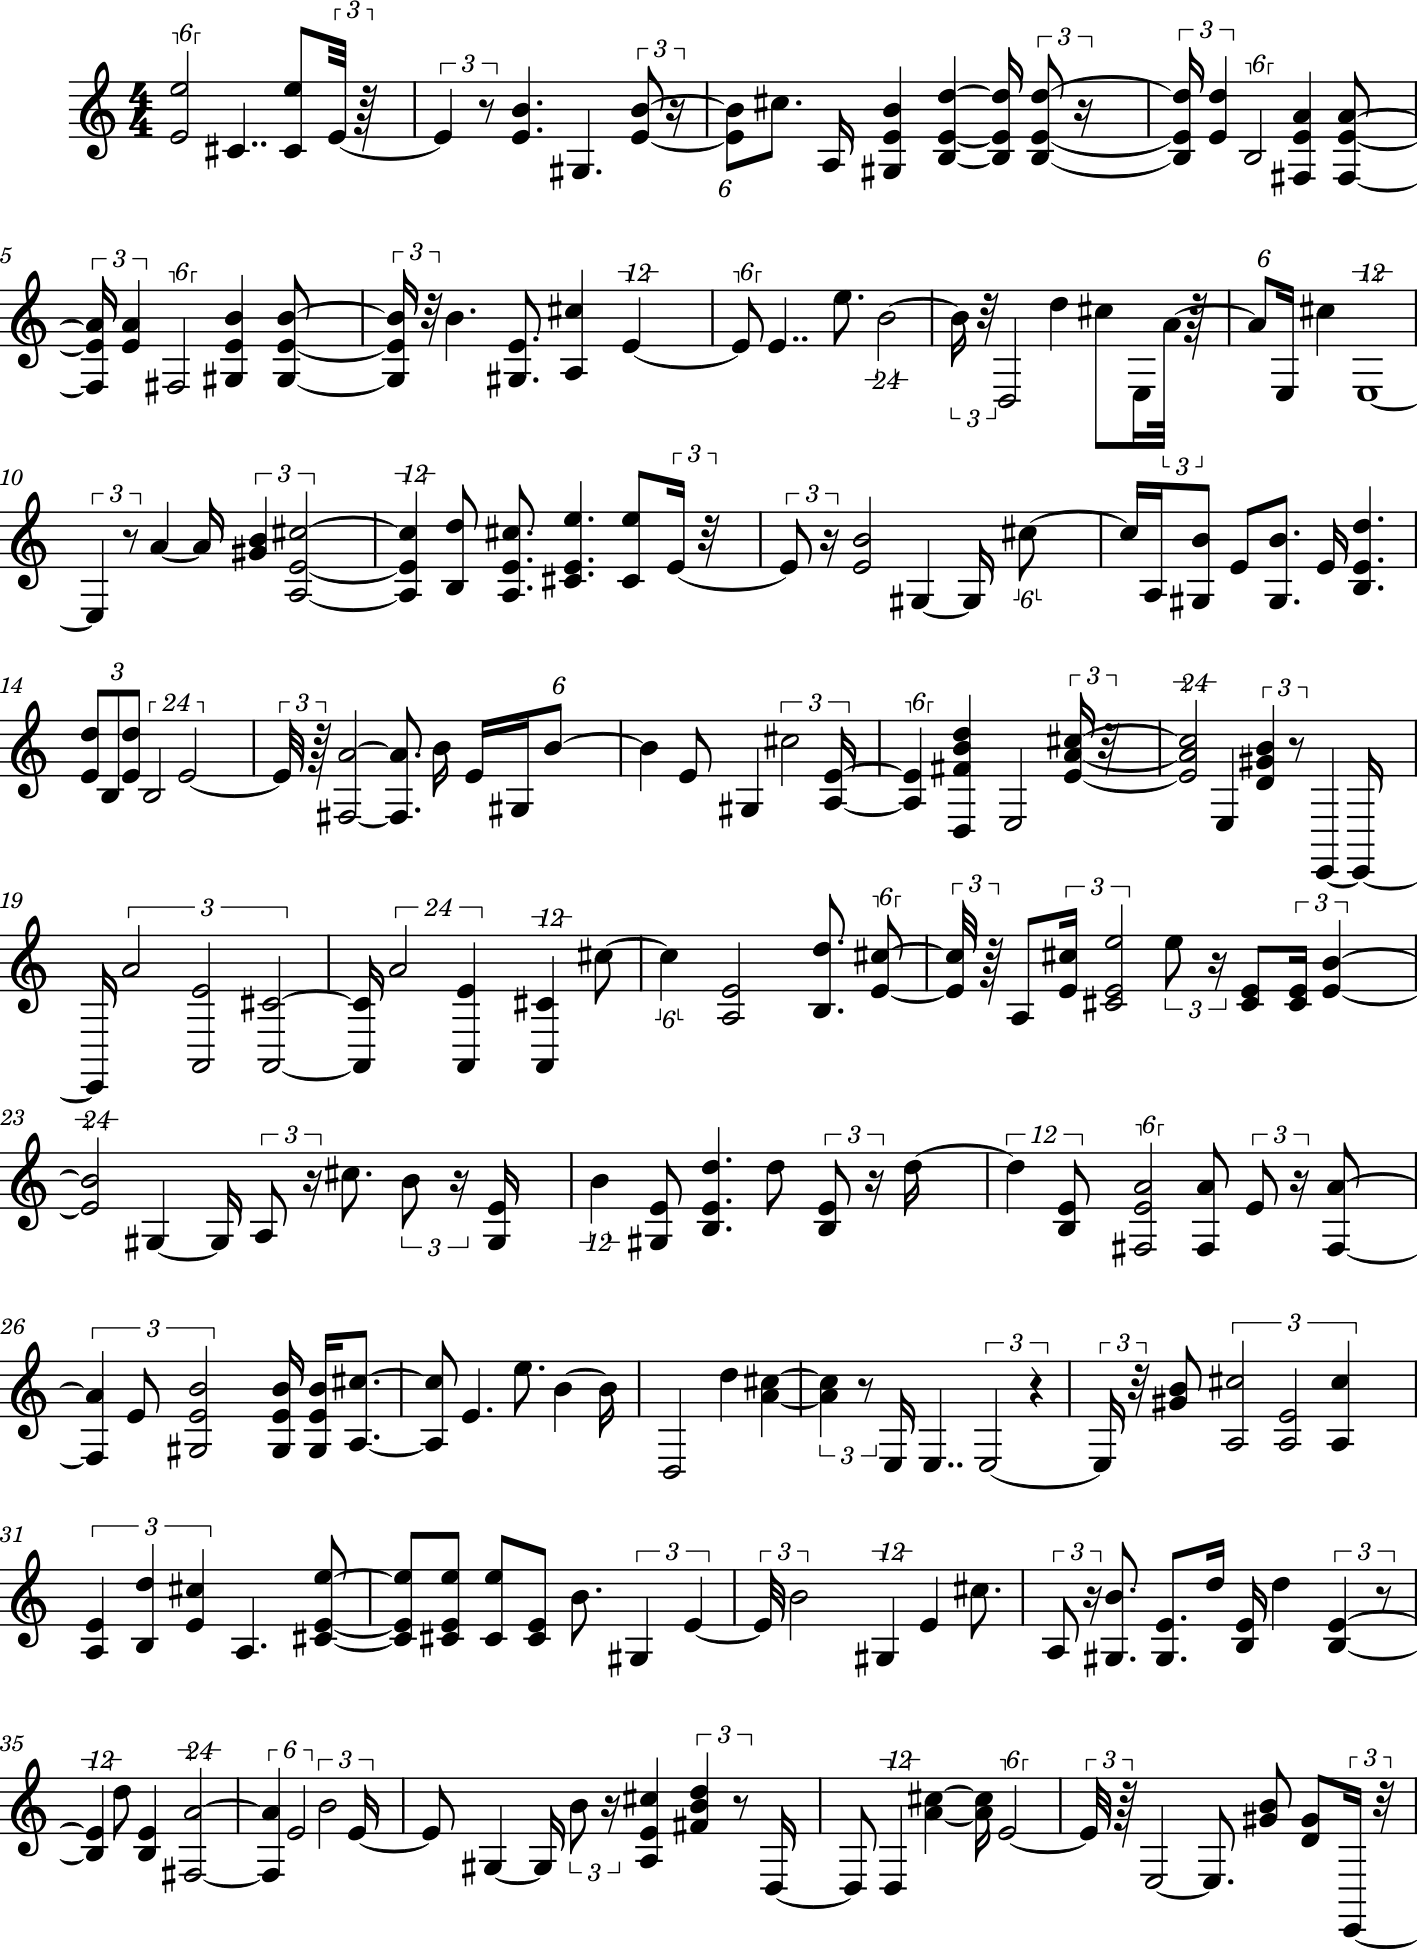

In [18]:
midi_stream.show()